In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

engine.dispose()

In [31]:
clean_df = df.copy()

for state in df.STATE.unique():
    clean_df[clean_df.STATE == state] = df[df.STATE == state].interpolate(limit_direction='both')
    
to_drop_array = []
for state in clean_df[pd.isnull(clean_df.ENROLL) == True].STATE:
    to_drop_array.append(state)
    
rows_to_drop = []
for row_index in range(len(clean_df)):
    if clean_df.STATE[row_index] in to_drop_array:
        rows_to_drop.append(row_index)
        
clean_df = clean_df.drop(clean_df.index[rows_to_drop])
clean_df.reset_index(drop=True, inplace=True)

In [34]:
weighted_score = []
for i in range(len(clean_df)):
    w1 = clean_df.GRADES_4_G[i]/(clean_df.GRADES_4_G[i] + clean_df.GRADES_8_G[i])
    w2 = 1 - w1
    weighted_score.append((clean_df.AVG_MATH_4_SCORE[i]*w1 + clean_df.AVG_MATH_8_SCORE[i]*w2 + clean_df.AVG_READING_4_SCORE[i]*w1 + clean_df.AVG_READING_8_SCORE[i]*w2)/2)
clean_df['WEIGHTED_SCORE'] = weighted_score

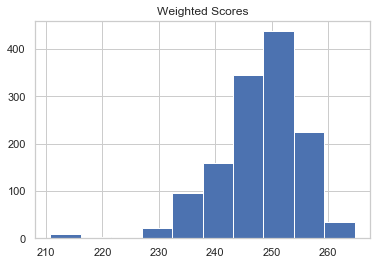

NormaltestResult(statistic=262.41062770653696, pvalue=1.0429324902274814e-57)


In [35]:
plt.hist(clean_df.WEIGHTED_SCORE)
plt.title('Weighted Scores')
plt.show()
print(stats.normaltest(clean_df.WEIGHTED_SCORE))

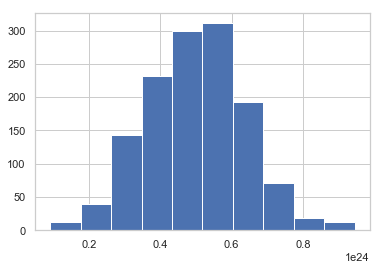

NormaltestResult(statistic=0.16720036847653486, pvalue=0.9197989326996941)


In [36]:
# Apply a boxcox transformation and our distribution is normal now!
boxcox_weighted,_ = stats.boxcox(clean_df.WEIGHTED_SCORE)
plt.hist(boxcox_weighted)
plt.show()
print(stats.normaltest(boxcox_weighted))

In [37]:
clean_df['BOXCOX_WEIGHTED_SCORE'] = boxcox_weighted

In [71]:
vars = ['BOXCOX_WEIGHTED_SCORE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
clean_df[vars].corr()

,BOXCOX_WEIGHTED_SCORE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
BOXCOX_WEIGHTED_SCORE,1.000000,0.113683,0.122228,0.122047,0.045309,0.037349
TOTAL_EXPENDITURE,0.113683,1.000000,0.991256,0.993101,0.945465,0.930754
INSTRUCTION_EXPENDITURE,0.122228,0.991256,1.000000,0.976215,0.908302,0.894034
SUPPORT_SERVICES_EXPENDITURE,0.122047,0.993101,0.976215,1.000000,0.953187,0.915849
OTHER_EXPENDITURE,0.045309,0.945465,0.908302,0.953187,1.000000,0.920382
CAPITAL_OUTLAY_EXPENDITURE,0.037349,0.930754,0.894034,0.915849,0.920382,1.000000


In [61]:
# These are all pretty low correlations, but instruction expenditure is the most highly correlated.

In [85]:
vars = ['TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
X = StandardScaler().fit_transform(clean_df[vars])
sklearn_pca = PCA(n_components=1)
clean_df["PCA_1"] = sklearn_pca.fit_transform(X)

In [86]:
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

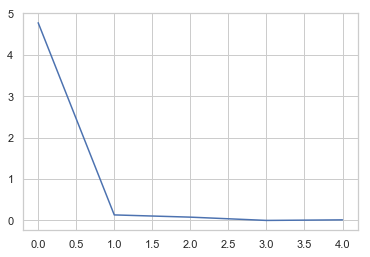

[0.95451058]


In [87]:
plt.plot(eig_val_cov)
plt.show()
print(sklearn_pca.explained_variance_ratio_)

In [78]:
# 95% of the total variance is explained by the first component.

In [90]:
vars = ['BOXCOX_WEIGHTED_SCORE', 'PCA_1', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
clean_df[vars].corr()

,BOXCOX_WEIGHTED_SCORE,PCA_1,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
BOXCOX_WEIGHTED_SCORE,1.000000,0.090715,0.113683,0.122228,0.122047,0.045309,0.037349
PCA_1,0.090715,1.000000,0.995311,0.976899,0.990813,0.967656,0.953683
TOTAL_EXPENDITURE,0.113683,0.995311,1.000000,0.991256,0.993101,0.945465,0.930754
INSTRUCTION_EXPENDITURE,0.122228,0.976899,0.991256,1.000000,0.976215,0.908302,0.894034
SUPPORT_SERVICES_EXPENDITURE,0.122047,0.990813,0.993101,0.976215,1.000000,0.953187,0.915849
OTHER_EXPENDITURE,0.045309,0.967656,0.945465,0.908302,0.953187,1.000000,0.920382
CAPITAL_OUTLAY_EXPENDITURE,0.037349,0.953683,0.930754,0.894034,0.915849,0.920382,1.000000
